In [1]:
import numpy as np
import matplotlib.pyplot as plt
from optic.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp import pnorm

# Transmissores Opticos

O primeiro passo para este estudo é entender como representar os sinais nas diferentes etapas do sistema. 

Ao transmitir sinais em um canal de comunicação como a fibra óptica, a intensidade e a fase da portadora são modificadas para transmitir informações tal processo e chamado de **modulação** o sinal modulado pode ser representado da seguinte maneira.

$$x(t)=\sqrt{2}A(t)\mathrm{cos}(2\pi f_{c}t+\phi(t))$$

onde $f_{c}$ é a frequência da portadora e $A(t)$ e $\phi(t)$ são a amplitude e a fase sendo os principais componentes de modulação. De forma alternativa podemos adotar outra representação dos sinais transmitidos que podem suprimir a dependência da frequência da portadora usando números complexos.

$$x_{b}(t)=x_{I}(t)+i x_{Q}(t).$$

Ou ainda podemos observala como representação fasorial cartesiana:

$$\begin{array}{l}{{{{x}}(t)=i A\sin\left(\theta\right)+A\cos\left(\theta\right)}}\\ \\ {{x_{I}=A\cos\left(\theta\right)}}\\ {{x_{Q}=A\sin\left(\theta\right)}}\end{array}$$

O sinal $x(t)$ e a representação do sinal em banda base. Em sistemas de transmissão digital com modulação de amplitude de pulso em banda base
(PAM), os sinais de tempo contínuo $x_{I}(t)$ e $x_{Q}(t)$ podem ser expressos como uma soma de
formas de onda contínuas com atraso de tempo onde $Ts$ é o período do símbolo.

$$\begin{array}{c}{{x_{I}(t)=\sum_{k}x_{k}^{I}g(t-k T_{s}),}}\\ {{{}}}\\ {{{x}_{Q}(t)=\sum_{k}x_{k}^{Q}g(t-k T_{s}),}}\end{array}$$

Uma família amplamente utilizada de formatos de modulação que alcança excelente desempenho é a modulação de amplitude em quadratura M-ária (M-QAM). No M-QAM, os níveis de amplitude M dos componentes em fase e quadratura são uniformemente distribuído e modulado independentemente. Normalmente, $M = L²$ e $L$ é uma potência de dois. Para fins de visualização podemos gerar diferentes formatos de modulação e suas respectivas constelações.

### Diagramas de Constelação M-QAM

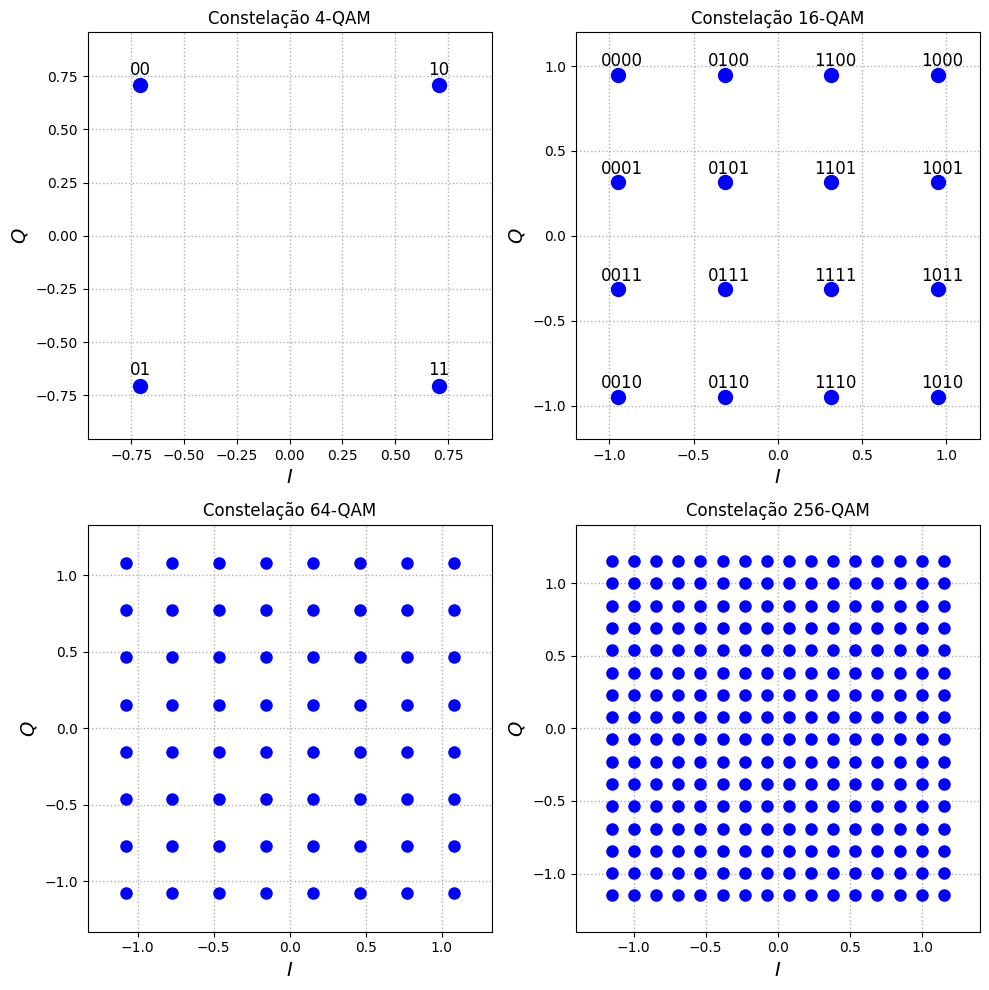

In [2]:
M = [4, 16, 64, 256]  # Ordem do formato de modulação.
constType = 'qam'  # 'qam', 'psk', 'pam' or 'ook'

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for idx, modulation in enumerate(M):
    # Gera os pontos cartesianos da constelação neste caso fasores para cada simbolo.
    constSymb = GrayMapping(modulation, constType)
    # Gera o mapeamento de bits, agrupando bits em matrizes para cada simbolo.
    bitMap = demodulateGray(constSymb, modulation, constType)
    bitMap = bitMap.reshape(-1, int(np.log2(modulation)))

    # Tomando uma sequência de bits aleatória.
    bits = bitMap.reshape(1, -1)
    # Mapeia os bits para os simbolos da constelação como um fasor.
    symbTx = modulateGray(bits, modulation, constType)

    # normaliza os simbolos da constelação para terem energia igual a 1.
    symbTx = pnorm(symbTx)

    row = idx // 2
    col = idx % 2

    # Plota a Constelação M-ária
    if modulation < 64:
        axs[row, col].plot(symbTx.real, symbTx.imag, 'o', color='b', markersize=10)
        axs[row, col].set_title('Constelação ' + str(modulation) + '-' + constType.upper())

        axs[row, col].set_xlim(min(symbTx.real) - 0.25, max(symbTx.real) + 0.25)
        axs[row, col].set_ylim(min(symbTx.real) - 0.25, max(symbTx.real) + 0.25)
        axs[row, col].set_xlabel('$I$', fontsize='14')
        axs[row, col].set_ylabel('$Q$', fontsize='14')
        axs[row, col].grid(linestyle="dotted", linewidth=1)

        for ind, symb in enumerate(pnorm(constSymb)):
            bitMap[ind, :]
            axs[row, col].annotate(str(bitMap[ind, :])[1:-1:2], xy=(symb.real - 0.025 * np.log2(modulation), symb.imag + 0.05), size=12)
    else:
        axs[row, col].plot(symbTx.real, symbTx.imag, 'o', color='b', markersize=8)
        axs[row, col].set_title('Constelação ' + str(modulation) + '-' + constType.upper())

        axs[row, col].set_xlim(min(symbTx.real) - 0.25, max(symbTx.real) + 0.25)
        axs[row, col].set_ylim(min(symbTx.real) - 0.25, max(symbTx.real) + 0.25)
        axs[row, col].set_xlabel('$I$', fontsize='14')
        axs[row, col].set_ylabel('$Q$', fontsize='14')
        axs[row, col].grid(linestyle="dotted", linewidth=1)

plt.tight_layout()
plt.show()

### 2.1 Critério de Nyquist e ISI

O critério de Nyquist determina a existência de uma família de formas de pulso para $g(t)$ cuja transmissão é realizada livre de interferência intersimbólica (ISI) essa é a condição para transmissão livre de ISI que pode ser expressa como:

$$\frac{1}{T_{s}}\sum_{m=-\infty}^{\infty}G\left(f-\frac{m}{T_{s}}\right)=1$$

A transmissão livre de ISI é alcançada se a soma das versões com mudança de frequência de $G(f)$ resulta em uma constante. Pulsos satisfatórios
para esta condição são chamados de pulsos de Nyquist. A forma do pulso de Nyquist com o mínimo de largura de banda de transmissão, $1/(2Ts)$, é obtida por um formato de pulso sinc:

$$g(t)=\frac{\sin(\pi t/T_{s})}{\pi t/T_{s}}$$

Os pulsos baseados na função sinc possuem duração infinita, o que dificulta sua aplicação prática. Alternativamente, os pulsos de cosseno elevado (RC) são pulsos de Nyquist cuja duração espectral e suporte são controlados por um fator de roll-off $\alpha^{\mathrm{RC}}$ que podem variar de 0 a 1. A resposta de frequência do filtro de modelagem RC é dada por:

$$H_{\mathrm{RC}}(f)={\left\{\begin{array}{l l}{1,{\mathrm{~if~}}|f|\lt {\frac{1-\alpha^{\mathrm{RC}}}{2T s}};}\\ {0,{\mathrm{~if~}}|f|\gt {\frac{1+\alpha^{\mathrm{RC}}}{2T s}};}\\ {0.5+0.5\mathrm{cos}\left({\frac{\overline{{{\pi Ts}}}}{\alpha^{\mathrm{RC}}}}\left(|f|-{\frac{1-\alpha^{\mathrm{RC}}}{2T s}}\right)\right\}}\end{array}\right.}$$

Em sistemas ópticos coerentes é possível trabalhar com fatores de roll-off bastante baixos, variando de 0.01 a 0.1, implementando um pulso
com espectro quase retangular. Porém, a geração de pulsos com valores tão baixos de roll-off são complexos, exigindo filtros moldados com centenas de coeficientes.

### Exemplo e Visualização

Quando transmitimos símbolos digitais, nós os transmitimos consecutivamente (em vez de esperar algum tempo entre eles). Quando você aplica um filtro de modelagem de pulso, ele alonga o pulso no domínio do tempo (para condensá-lo em frequência), o que faz com que os símbolos adjacentes se sobreponham.

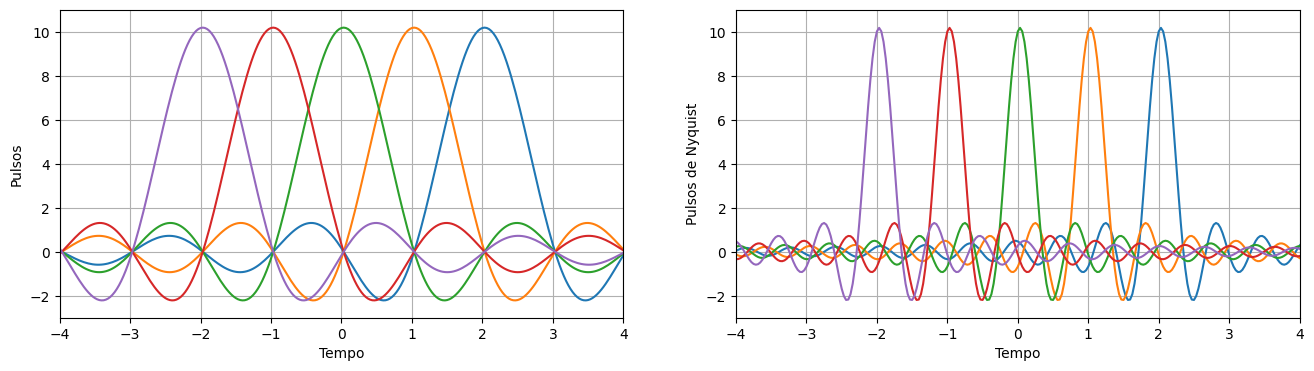

In [3]:
SpS = 32  # Taxa de símbolos
Ts = SpS  # Supondo que a taxa de amostragem seja 1 Hz, então o período de amostragem é 1.

num_taps = 2001
t = np.arange(num_taps // -2, num_taps // 2)

sinc = np.sinc(t / Ts)
sinc_Nyquist = np.sinc(np.pi * t/ Ts)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

for delay in np.arange(-2, 3):
    x_shaped = np.convolve(np.sinc(np.pi*(t + delay * SpS) / Ts), sinc, 'same')
    x_nyquist = np.convolve(np.sinc(np.pi*(t + delay * SpS) / Ts), sinc_Nyquist, 'same')
    ax1.plot(t / Ts, x_shaped)
    ax2.plot(t / Ts, x_nyquist)

for plot in [ax1, ax2]:
    plot.axis([-3, 3, -3, 11])
    plot.set_xlabel("Tempo")
    plot.set_ylabel("Pulsos")
    if plot == ax2:
        plot.set_ylabel("Pulsos de Nyquist")
    plot.set_xticks(np.arange(-4, 5));
    plot.grid()

Quando o receptor amostra o sinal, ele o faz no momento perfeito (no pico dos pulsos), o que significa que esse é o único momento que importa. Geralmente há um bloco de sincronização de símbolos no receptor que garante que os símbolos sejam amostrados nos picos.

Resposta ao Impulso do filtro:
$$h(t)=\frac{1}{T}\mathrm{sinc}\left(\frac{t}{T}\right)\frac{\cos\left(\frac{\pi\beta t}{T}\right)}{1-\left(\frac{2\beta t}{T}\right)^{2}}$$

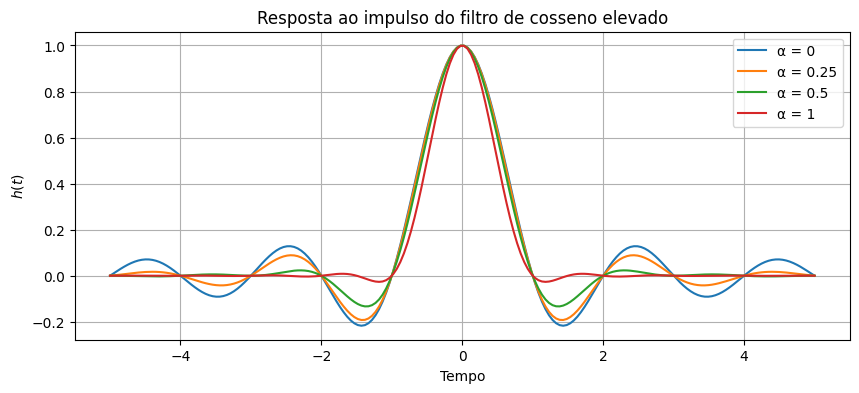

In [81]:
SpS = 4
t = np.linspace(-5*SpS, 5*SpS, 200)

rolloff = []
plt.figure(num=None, figsize=(10, 4))

for alpha in [0, 0.25, 0.5, 1]:
    h = np.sinc(t/SpS)*np.cos(np.pi*alpha*t/SpS)/(1-(2*alpha*t/SpS)**2) # Resposta ao impulso do filtro.
    plt.plot(t/SpS, h)
    rolloff.append('α = ' + str(alpha))

plt.title("Resposta ao impulso do filtro de cosseno elevado")
plt.xlabel("Tempo")
plt.ylabel("$h(t)$")
plt.legend(rolloff)
plt.grid(True)

Assim o filtro pode limitar a largura de banda que nosso sinal ocupará, cuja duração espectral e suporte são controlados por um fator de roll-off $\alpha$ que determina a rapidez com que o filtro diminui no domínio do tempo, o que será inversamente proporcional à rapidez com que diminui em frequência.

Uma vez que olhamos para as respostas do filtro em diferentes valores de $\alpha$, podemos ver que a largura de banda necessária para capturar nosso sinal aumenta e é daí que vem seu outro nome, excesso de largura de banda. O parâmetro $\alpha$ é uma compensação entre quanto vazamento espectral você está permitindo para frequências próximas e quanta largura de banda será necessária para recuperar o sinal transmitido.

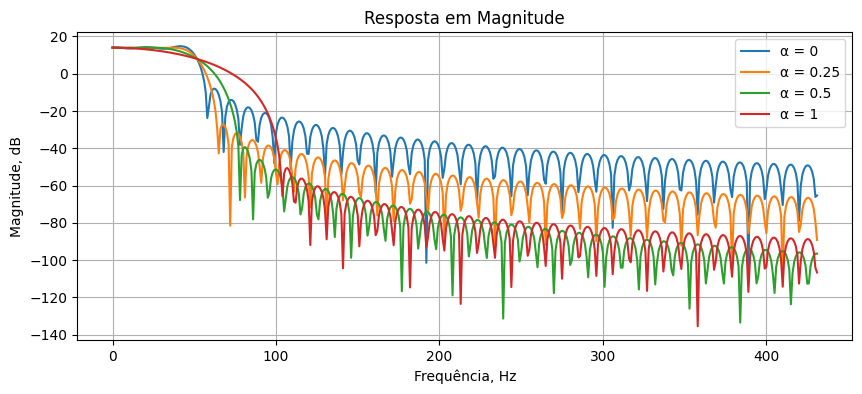

In [80]:
SpS = 4
fft_size = 2064
t = np.linspace(-5*SpS, 5*SpS, 200)

rolloff = []
plt.figure(num=None, figsize=(10, 4))

for alpha in [0, 0.25, 0.5, 1]:
    h = np.sinc(t/SpS)*np.cos(np.pi*alpha*t/SpS)/(1-(2*alpha*t/SpS)**2)
    rcos_response = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(h, fft_size)))/SpS)
    plt.plot(rcos_response[int(fft_size/2):-600])
    rolloff.append('α = ' + str(alpha))

plt.title("Resposta em Magnitude")
plt.xlabel("Frequência, Hz")
plt.ylabel("Magnitude, dB")
plt.legend(rolloff)
plt.grid(True)

## Modulação Óptica

### 2.2 Lasers

Em sistemas de comunicações ópticas, a portadora é geralmente produzida por semicondutores lasers e diodos emissores de luz (LEDs). Para transmissão de longa distância com
detecção, vamos assumir que todas as portadores são gerados por lasers.

As principais vantagens de lasers sobre outras fontes de luz são seu feixe colimado, intensidades relativamente altas e coerência. Para transmissão óptica de longa distância, a coerência é de fundamental importância, especialmente para sistemas com modulação de fase e detecção coerente. À medida que modulamos a fase da portadora gerada, o ruído de fase deve ser relativamente baixo para evitar prejuízos no processo de detecção. Os lasers usados na detecção coerente requerem uma largura de linha particularmente estreita, para servir como uma fonte de referência adequada para detecção de fase.

Vamos supor que a saída do laser tenha intensidade constante (desprezando assim a intensidade do ruído), o campo elétrico em sua saída é dado por:

$$E_{l}(t)=E_{0}e^{j\phi_{n}(t)}$$

onde $E_0$ é uma amplitude de campo constante e $\phi_{n}(t)$ é o processo de ruído de fase. A largura de linha diferente de zero dos lasers dá origem a um processo de ruído de fase que é bem modelado por um processo de Wiener de tempo contínuo. Também é importante sabermos que o ruído de fase dos lasers transmissores e receptores resulta em rotações nas constelações recebidas. Em sistemas ópticos coerentes, essas rotações são compensadas em DSP por algoritmos de recuperação de fase.

### 2.3 Processo de Modulação

Em sistemas de comunicação por fibra óptica, a modulação direta é a técnica mais simples usada para modular uma portadora óptica. A modulação direta modifica a corrente de acionamento de um laser semicondutor causando variações na amplitude do sinal óptico gerado de acordo com a informação a ser enviada. 

Como desvantagem, esse tipo de modulação produz pulsos que são afetados pelo chirp, que são variações contínuas da frequência óptica durante um período de símbolo. Uma desvantagem da modulação direta é a incapacidade de acompanhar variações rápidas na tensão de acionamento. Apesar dessas desvantagens, a modulação é amplamente utilizada em sistemas ópticos de curto alcance com modulação de intensidade e detecção direta, principalmente por sua simplicidade e baixo custo.

Alternativamente, a modulação externa é usada na maioria dos sistemas de alta taxa. Esta técnica de modulação requer a utilização de um componente extra, o **modulador óptico**, que é acoplado na saída da fonte óptica. Variações de fase, amplitude ou uma combinação das duas podem ser realizadas de acordo com sinais elétricos representativos da informação a ser enviada. Embora aumente a complexidade do transmissor, a modulação externa proporciona um desempenho do sistema consideravelmente melhor em comparação com a modulação direta, minimizando vários efeitos indesejados, particularmente as limitações de chirp e de largura de banda.

# Referências 

[1] Digital Coherent Optical Systems, Architecture and Algorithms